<a href="https://colab.research.google.com/github/HaykalRamadhan/forecasting/blob/main/UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# THIS IS THE START OF CODE

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load data
ct = pd.read_csv('/content/drive/MyDrive/UP/sample_data/Monthly_Sales_Summary.csv')

In [ ]:
# Convert 'Transaksi' (string YYYY-MM) to numeric value (year + month/12)
ct[['Year', 'Month']] = ct['Transaksi'].str.split('-', expand=True)
ct['Year'] = ct['Year'].astype(int)
ct['Month'] = ct['Month'].astype(int)
ct['Transaksi_Numeric'] = ct['Year'] + (ct['Month'] / 12)

In [ ]:
# Sort by numeric
ct = ct.sort_values(by="Transaksi_Numeric")

In [ ]:
# Define X and Y
x = np.array(ct["Transaksi_Numeric"])
y = np.array(ct["Total"])

print(x)
print(y)

In [ ]:
# Function to compute R2 manually
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tss)
    return r2_score

In [ ]:
# Future prediction points (next 3 months)
last_year = ct['Year'].max()
last_month = ct[ct['Year'] == last_year]['Month'].max()
future_dates = []
for i in range(1, 4):
    new_month = last_month + i
    new_year = last_year
    if new_month > 12:
        new_year += 1
        new_month -= 12
    future_numeric = new_year + (new_month / 12)
    future_dates.append(future_numeric)
x2 = np.array(future_dates)


--- Polynomial Regression Degree 2 ---
R2 Score: 0.8993
Future Predictions:
Transaksi 2025-03: Predicted Total = 9277098.75
Transaksi 2025-04: Predicted Total = 7043623.98
Transaksi 2025-05: Predicted Total = 4491853.56


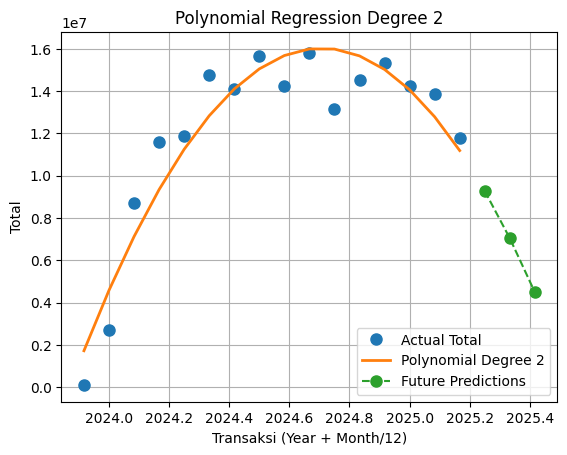


--- Polynomial Regression Degree 3 ---
R2 Score: 0.9493
Future Predictions:
Transaksi 2025-03: Predicted Total = 13084896.00
Transaksi 2025-04: Predicted Total = 13539424.00
Transaksi 2025-05: Predicted Total = 14422144.00


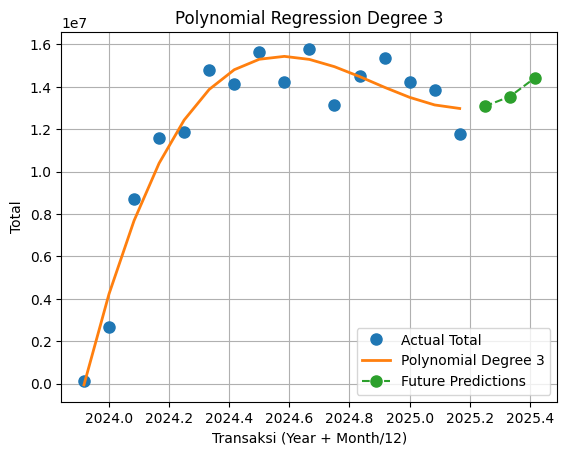


--- Polynomial Regression Degree 4 ---
R2 Score: 0.9493
Future Predictions:
Transaksi 2025-03: Predicted Total = 13085472.00
Transaksi 2025-04: Predicted Total = 13540448.00
Transaksi 2025-05: Predicted Total = 14424096.00


<ipython-input-14-5b9e37b01788>:5: RankWarning: Polyfit may be poorly conditioned
  AB = np.polyfit(x, y, degree)


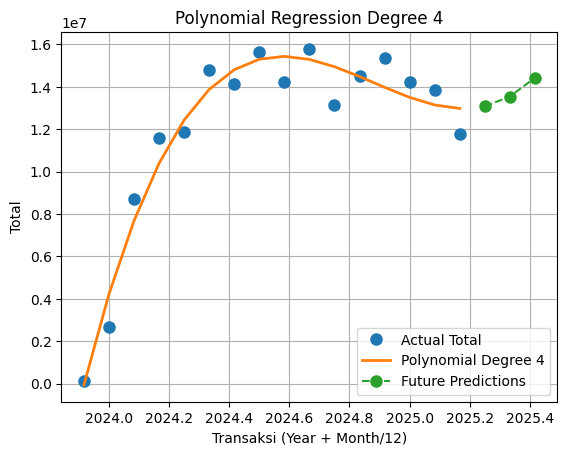

In [ ]:
# Polynomial regression degrees 2, 3, 4
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")

    AB = np.polyfit(x, y, degree)
    func = np.poly1d(AB)

    y_p = func(x)   # prediction for existing points
    y_p2 = func(x2) # prediction for future points

    # Compute R2
    r2 = compute_r2(y, y_p)
    print(f"R2 Score: {r2:.4f}")
    print("Future Predictions:")
    for trans, pred in zip(x2, y_p2):
        year = int(trans)
        month = int(round((trans - year) * 12))
        if month == 0:
            month = 12
            year -= 1
        print(f"Transaksi {year}-{str(month).zfill(2)}: Predicted Total = {pred:.2f}")

    plt.plot(x, y, linestyle="none", marker='o', markersize=8, label='Actual Total')
    plt.plot(x, y_p, linewidth=2, label=f'Polynomial Degree {degree}')
    plt.plot(x2, y_p2, marker='o', linestyle='dashed', markersize=8, label='Future Predictions')
    plt.xlabel('Transaksi (Year + Month/12)')
    plt.ylabel('Total')
    plt.title(f'Polynomial Regression Degree {degree}')
    plt.legend()
    plt.grid(True)
    plt.show()


# THIS IS WEEKLY


--- Polynomial Regression Degree 2 ---
R² Score: 0.8762
Future Predictions:
Transaksi 2025-03: Predicted Total = 12743216.34
Transaksi 2025-04: Predicted Total = 12574387.04
Transaksi 2025-05: Predicted Total = 12399546.34


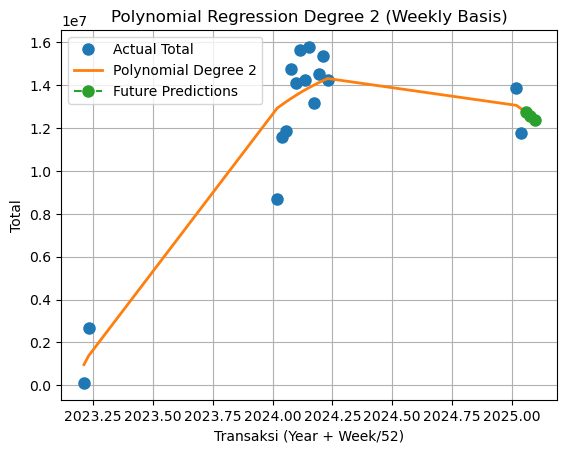


--- Polynomial Regression Degree 3 ---
R² Score: 0.9049
Future Predictions:
Transaksi 2025-03: Predicted Total = 11769120.00
Transaksi 2025-04: Predicted Total = 11029344.00
Transaksi 2025-05: Predicted Total = 10249856.00


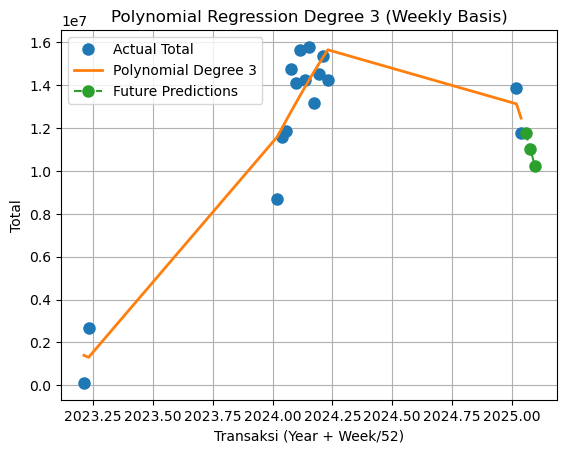


--- Polynomial Regression Degree 4 ---
R² Score: 0.9049
Future Predictions:
Transaksi 2025-03: Predicted Total = 11768840.00
Transaksi 2025-04: Predicted Total = 11028888.00
Transaksi 2025-05: Predicted Total = 10249184.00


C:\Users\Haykal\AppData\Local\Temp\ipykernel_12840\3689986986.py:56: RankWarning: Polyfit may be poorly conditioned
  AB = np.polyfit(x, y, degree)


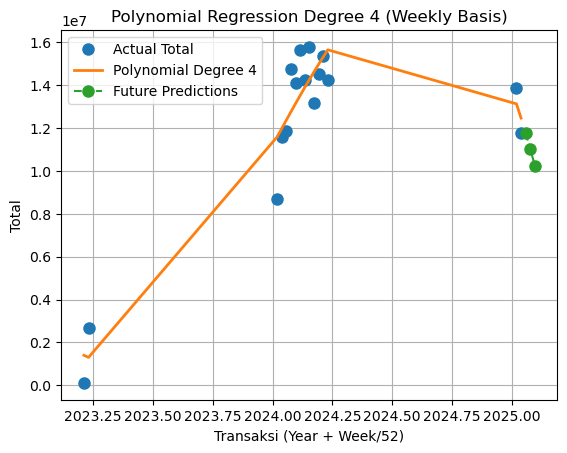

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Ask user for file path input
file_path = input("Enter the full path to your CSV file (example: C:\\Users\\Haykal\\Desktop\\Monthly_Sales_Summary.csv):\n")

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load data
ct = pd.read_csv(file_path)

# Convert 'Transaksi' (string YYYY-WW) to numeric value (year + week/52)
ct[['Year', 'Week']] = ct['Transaksi'].str.split('-', expand=True)
ct['Year'] = ct['Year'].astype(int)
ct['Week'] = ct['Week'].astype(int)
ct['Transaksi_Numeric'] = ct['Year'] + (ct['Week'] / 52)

# Sort by numeric transaksi
ct = ct.sort_values(by="Transaksi_Numeric")

# X and Y
x = np.array(ct["Transaksi_Numeric"])
y = np.array(ct["Total"])

# Function to compute R² manually
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tss)
    return r2_score

# Future prediction points (next 3 weeks)
last_year = ct['Year'].max()
last_week = ct[ct['Year'] == last_year]['Week'].max()

# Add 1, 2, 3 weeks
future_dates = []
for i in range(1, 4):
    new_week = last_week + i
    new_year = last_year
    if new_week > 52:
        new_year += 1
        new_week -= 52
    future_numeric = new_year + (new_week / 52)
    future_dates.append(future_numeric)
x2 = np.array(future_dates)

# Polynomial regression degrees 2, 3, 4
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")

    AB = np.polyfit(x, y, degree)
    func = np.poly1d(AB)

    y_p = func(x)   # prediction for existing points
    y_p2 = func(x2) # prediction for future points

    # Compute R²
    r2 = compute_r2(y, y_p)
    print(f"R² Score: {r2:.4f}")
    print("Future Predictions:")
    for trans, pred in zip(x2, y_p2):
        year = int(trans)
        week = int(round((trans - year) * 52))
        if week == 0:
            week = 52
            year -= 1
        print(f"Transaksi {year}-{str(week).zfill(2)}: Predicted Total = {pred:.2f}")

    # Plot
    plt.plot(x, y, linestyle="none", marker='o', markersize=8, label='Actual Total')
    plt.plot(x, y_p, linewidth=2, label=f'Polynomial Degree {degree}')
    plt.plot(x2, y_p2, marker='o', linestyle='dashed', markersize=8, label='Future Predictions')
    plt.xlabel('Transaksi (Year + Week/52)')
    plt.ylabel('Total')
    plt.title(f'Polynomial Regression Degree {degree} (Weekly Basis)')
    plt.legend()
    plt.grid(True)
    plt.show()
